<a id='Jump'></a>
## This part is used to Jump to any where u want 
How to use 

add there  `<a id='The_wanted_Cell_ID'></a>`<br>
and in here add  `[Displayed here name](#The_wanted_Cell_ID)`
### [Edit the Path](#path)

### [Feature Selection](#Feature_Selection) <br>

## Models
### [Random Forest Train](#Random_Forest)
### [XGB Train Model](#XGB_train) [Try Grid search](#Try_grid_search)
### [GBRegressor Train](#GBRegressor_train)
### [CatBoost train](#CatBoosttrain)
### [Stacking](#Stacking_train)
### [bagging](#bagging_test)
<br>

### [Submission Preparation](#Submission_Preparation)
### [model Predictions](#model_Predictions)
### [Save Submission](#Save_Submission)

### Imports

In [317]:
import numpy as np
import pandas as pd

In [318]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
import xgboost as xgb
import catboost as cb


In [190]:
#---------- configs
pd.set_option('max_rows',100)
pd.set_option('max_columns',40)

<a id='path'></a>
### loading data
##### [Jump Top](#Jump)

In [191]:
#Mohey Path
train_path = r"input\seoul-bike-rental-ai-pro-iti\train.csv"
test_path = r"input\seoul-bike-rental-ai-pro-iti\test.csv"

In [192]:
df = pd.read_csv(train_path,index_col=0,parse_dates=['Date'],dayfirst=True)
df_test = pd.read_csv(test_path,parse_dates=['Date'],dayfirst=True)

df = df.rename(columns={'Temperature(�C)':'Temperature(C)'
                        ,'Dew point temperature(�C)'  : 'Dew point temperature(C)'})
df_test = df_test.rename(columns={'Temperature(�C)':'Temperature(C)'
                                  ,'Dew point temperature(�C)'  : 'Dew point temperature(C)'})

## Feature Engineering

##### based on the previous notebook (eda) we will consider the following 

- A) The Hourly cycle has a good correlation. [7am-18pm has the bigger share]
- B) The Temperature has good corr. [high is good except > ~ 27]
- C) The Functional Day has good corr. [functional is good for target]
- D) The Seasons has good corr. [hot season is better]

-------------

- E) The Visibility may prove to be good. [if encoded to very_low visibility vs normal visibiliy].
- F) The RainFall/SnowFall may prove to be good. [if encoded to Snowing / Raining or not].
- G) The Humidity may have something to investigate. [if encoded as 0-80 % normal rentals, 80-100% show sharp decay in rentals]

---------------
- H) the Dew point temperature is strongly corr to Temperature will drop it.
- I) the Solar Radiation may be discarded .. i didn't see good relation.
- J) the holidays didn't prove decisive saying on our target. maybe discarded too.

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5760 entries, 0 to 5759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      5760 non-null   datetime64[ns]
 1   y                         5760 non-null   int64         
 2   Hour                      5760 non-null   int64         
 3   Temperature(C)            5760 non-null   float64       
 4   Humidity(%)               5760 non-null   int64         
 5   Wind speed (m/s)          5760 non-null   float64       
 6   Visibility (10m)          5760 non-null   int64         
 7   Dew point temperature(C)  5760 non-null   float64       
 8   Solar Radiation (MJ/m2)   5760 non-null   float64       
 9   Rainfall(mm)              5760 non-null   float64       
 10  Snowfall (cm)             5760 non-null   float64       
 11  Seasons                   5760 non-null   object        
 12  Holiday             

In [194]:
df.describe()

y         Hour  Temperature(C)  Humidity(%)  \
count  5760.000000  5760.000000     5760.000000  5760.000000   
mean    703.483854    11.500000       12.803559    58.361806   
std     655.249491     6.922788       11.902206    19.840167   
min       0.000000     0.000000      -15.100000     0.000000   
25%     188.000000     5.750000        3.200000    43.000000   
50%     485.500000    11.500000       13.700000    57.000000   
75%    1066.000000    17.250000       22.225000    73.000000   
max    3556.000000    23.000000       39.400000    98.000000   

       Wind speed (m/s)  Visibility (10m)  Dew point temperature(C)  \
count       5760.000000       5760.000000               5760.000000   
mean           1.723333       1473.711458                  4.058264   
std            1.047898        585.879880                 13.003582   
min            0.000000         27.000000                -26.900000   
25%            0.900000       1025.750000                 -5.400000   
50%            1.500000       1732.000000                  5.200000   
75%            2.300000       2000.000000                 14.700000   
max            7.400000       2000.000000                 27.200000   

       Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  
count              5760.000000   5760.000000    5760.000000  
mean                  0.572325      0.135122       0.046302  
std                   0.869943      1.075320       0.323728  
min                   0.000000      0.000000       0.000000  
25%                   0.000000      0.000000       0.000000  
50%                   0.010000      0.000000       0.000000  
75%                   0.940000      0.000000       0.000000  
max                   3.520000     35.000000       5.100000

In [195]:
df['Seasons'].value_counts()

Summer    1440
Winter    1440
Autumn    1440
Spring    1440
Name: Seasons, dtype: int64

In [196]:
df_prep = df.copy()

In [197]:
df_prep['Year'] = df['Date'].dt.year.astype('int')
df_prep['Week'] = df['Date'].dt.isocalendar().week.astype('int')
df_prep['Month'] = df['Date'].dt.month.astype('int')
df_prep['WeekDay'] = df['Date'].dt.weekday.astype('int')

In [198]:
def restore_data_series(dataframe,dforiginal,col_name):
    dataframe[col_name] = dforiginal[col_name]

In [199]:
def map_data_series(dataframe,col_name,from_vals,to_vals):
    dataframe[col_name].replace(from_vals,to_vals,inplace=True)

In [200]:
def new_feature_data_series(dataframe,col_name,function,new_col_name):
       dataframe[new_col_name]  = dataframe[col_name].apply(function,axis=1)

In [201]:
map_data_series(df_prep,'Functioning Day',['Yes','No'],[1,0])

In [202]:
map_data_series(df_prep,'Holiday',['Holiday','No Holiday'],[1,0])

In [203]:
map_data_series(df_prep,'Seasons',['Winter','Spring','Summer','Autumn'],[0,1,2,3])

In [204]:
## lambda df : 0 if ( (abs(df['Hour'] - 8) <=rush_range_1) or (abs(df['Hour'] - 18) <= rush_range_2) ) else 1
def rush_hour(df):
    #rush_range_1 = 2 # around the rush hour by +- 2 hrs
    #rush_range_2 = 4 # around the rush hour by +- 4 hrs
    if (df['Hour'] in [6,7,8,9,10,16,17,18,19,20]):
        return 1
    else:
        return 0
    
def rush_hour_grad_2(df):
    rush_range_1 = 2 # around the rush hour by +- 2 hrs
    rush_range_2 = 5 # around the rush hour by +- 4 hrs
    is_functional = df['Functioning Day']

    return (np.exp(-abs(df['Hour'] - 8)) +  np.exp(-abs(df['Hour'] - 18))) * is_functional

def rush_hour_grad(df):
    #from 8 am , 6 pm
    rush_range_1 = 2 # around the rush hour by +- 2 hrs
    rush_range_2 = 5 # around the rush hour by +- 4 hrs
    is_functional = df['Functioning Day'] 
    
    if (abs(df['Hour'] - 8) <= rush_range_1): 
        return np.exp(-abs(df['Hour'] - 8)) * is_functional
    
    elif (abs(df['Hour'] - 18) <= rush_range_2):
        return np.exp(-abs(df['Hour'] - 18)) * is_functional
    else:
        return 0
    
def dead_hour_grad(df):
    dead_range_1 = 3 # around the dead hour by +- 3 hrs from 4 am
    is_functional = df['Functioning Day'] 
    
    if (abs(df['Hour'] - 4) <= dead_range_1): 
        return np.exp(-abs(df['Hour'] - 4)) * is_functional
    else:
        return 0
    
def dead_hour_grad_2(df):
    #dead_range_1 = 5 # around the dead hour by +- 3 hrs from 4 am
    is_functional = df['Functioning Day'] 
    
    if(df['Hour'] in [22,23,0,1,2,3,4,5]):
        return np.exp(-abs(df['Hour'] - 4)) * is_functional
    else:
        return 0   
new_feature_data_series(df_prep,['Hour','Functioning Day'],rush_hour_grad,'Rush_hour')
new_feature_data_series(df_prep,['Hour','Functioning Day'],dead_hour_grad_2,'Dead_hour')

In [205]:
## lambda df : 0 if ( (abs(df['Hour'] - 8) <=rush_range_1) or (abs(df['Hour'] - 18) <= rush_range_2) ) else 1
def day_night(df):
    #rush_range_1 = 2 # around the rush hour by +- 2 hrs
    #rush_range_2 = 4 # around the rush hour by +- 4 hrs
    if (df['Hour'] >=6 and df['Hour'] <=18):
        return 1
    else:
        return 0

new_feature_data_series(df_prep,['Hour'],day_night,'day_night')

In [206]:
new_feature_data_series(df_prep,['Humidity(%)'],lambda df : 0 if (df['Humidity(%)'] <= 70) else 1,'Humidity_high')

In [207]:
new_feature_data_series(df_prep,['Temperature(C)'],lambda df : 0 if (df['Temperature(C)'] <= 35) else 1,'Temperature_high')

In [208]:
new_feature_data_series(df_prep,['Humidity(%)','Temperature(C)','Solar Radiation (MJ/m2)','Wind speed (m/s)'],lambda df : 0 if (df['Temperature(C)'] < 35) and (df['Humidity(%)'] < 70) and (df['Solar Radiation (MJ/m2)'] < 1.4) else 1,'Weather_bad')

In [209]:
#something is wrong in feels like equation
# def feels_like(df):
#     ### inputs temp & humidity , outputs feels like temp
#     ## equation heat_index = c1 + c2 T + c3 R + c4 TR + c5 T^2 + c6 R^2 +...
#     c1 = -8.78469475556
#     c2 = 1.61139411
#     c3 = 2.33854883889
#     c4 = -0.14611605
#     c5 = -0.012308094
#     c6 = -0.0164248277778
#     c7 = 0.002211732
#     c8 = 0.00072546
#     c9 = -0.000003582
#     T = df['Temperature(C)']
#     R = df['Humidity(%)']
#     is_functionalDay = df['Functioning Day']
#     HI = (c1) + (c2 * T) +( c3 * R) + (c4  * T * R )+ (c5 *( T**2 ))+ (c6 * (R**2)) + (c7 * (T**2) * R) + (c8 * T * (R**2)) + (c9 * (T**2) * (R**2))
#     #HI = c1 + (c2 * T) +( c3 * R )+ (c4  * T * R )+ (c5 * T**2 )
#     return HI 

#new_feature_data_series(df_prep,['Temperature(C)','Humidity(%)','Functioning Day'],feels_like,'Feels_like')
def humidex(df):
    ### humidex
    ## eq H = Tair + 5/9 * [(6.11 * e^5417.7530 * (a-b)) - 10 ]
    Tair = df['Temperature(C)']
    Tdew = df['Dew point temperature(C)']
    is_functionalDay = df['Functioning Day']
    a = 1/273.16
    b = 1/(273.15 + Tdew)
    Humidex = Tair + (5/9) * (6.11 * np.exp(5417.7530 * (a-b)) -10)
    return Humidex  
new_feature_data_series(df_prep,['Temperature(C)','Dew point temperature(C)','Functioning Day'],humidex,'Humidex')

In [210]:
df_prep['Ideal'] = df[['Temperature(C)', 'Wind speed (m/s)']] \
    .apply(lambda df: 1 if (df['Temperature(C)'] < 30 and df['Wind speed (m/s)'] < 2.8) else 0, axis = 1)

In [211]:
df_prep["Ideal"].value_counts()

1    4548
0    1212
Name: Ideal, dtype: int64

In [212]:
def visibility(df):
    #0:250 , 250:500 : 500:inf
    
    if df['Visibility (10m)'] <=250 :
        return 0
    elif df['Visibility (10m)'] <=350 :
        return 1
    elif df['Visibility (10m)'] <=450 :
        return 1
    elif df['Visibility (10m)'] <=550 :
        return 2
    elif df['Visibility (10m)'] <=650 :
        return 2
    elif df['Visibility (10m)'] <=850 :
        return 3
    elif df['Visibility (10m)'] <=1150 :
        return 3
    elif df['Visibility (10m)'] <=1350 :
        return 4
    else:
        return 5
    
new_feature_data_series(df_prep,['Visibility (10m)'],visibility,'Visibility_cat')

In [213]:
def visibility_dist(df):
    #0:250 , 250:500 : 500:inf
    
    if df['Visibility (10m)'] <100 :     #can't see
        return 1
    elif df['Visibility (10m)'] <400 :   # foggy
        return 2
    elif df['Visibility (10m)'] <1000 :  # low fog
        return 3
    elif df['Visibility (10m)'] <2000 :  # no fog (good vision)
        return 4
    elif df['Visibility (10m)'] <4000 :  # no fog (excellent vision)
        return 5
    else:
        return 5
    
new_feature_data_series(df_prep,['Visibility (10m)'],visibility_dist,'Visibility_dist')

In [214]:
# for rainfall

def rain_fall(df):
    # 0:2.5 , 
    
    if df['Rainfall(mm)'] < 0.5 :
        return 0
    else:
        return 1

new_feature_data_series(df_prep,['Rainfall(mm)'],rain_fall,'Rain_cat')

In [215]:
def snow_fall(df):
    # 0:2.5 , 
    
    if df['Snowfall (cm)'] == 0 :
        return 0
    else:
        return 1

new_feature_data_series(df_prep,['Snowfall (cm)'],snow_fall,'Snow_cat')

In [216]:
def Sunny_Hot (df):
    if ((df['Temperature(C)']>25)&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_hot (df):
    if ((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))\
                                   &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_hot(df):  
    if((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))\
                                                       &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_hot(df): 
    if((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_hot(df):  
    if((df['Temperature(C)']>25)&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def Night_hot(df): 
    if((df['Temperature(C)']>25)&(df['day_night']==0)
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

#len(sunny_hot)+len(Clear_hot)+len(PCloudy_hot)+len(Cloudy_hot)+len(Rain_hot)+len(Night_hot)

In [217]:
def Sunny_Warm (df):
    if (((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Warm (df):
    if (((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
        &(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))&(df['day_night']==1))\
        &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Warm(df):  
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_Warm(df): 
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Warm(df):  
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def Night_Warm(df): 
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(df['day_night']==0)&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

In [218]:
def Sunny_Cold (df):
    if (((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Cold (df):
    if (((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
        &(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))&(df['day_night']==1))\
        &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_Cold(df): 
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Snow_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&(df['Rainfall(mm)'] ==0)&(df['Snowfall (cm)'] >0)):
        return True
    else:
        return False
def Night_Cold(df): 
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(df['day_night']==0)&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

In [219]:
def Sunny_Freezing (df):
    if ((df['Temperature(C)']<=0)&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Freezing (df):
    if ((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))\
                                   &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Freezing(df):  
    if((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))\
                                                       &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_Freezing(df): 
    if((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Freezing(df):  
    if((df['Temperature(C)']<=0)&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Snow_Freezing(df):  
    if((df['Temperature(C)']<=0)&(df['Rainfall(mm)'] ==0)&(df['Snowfall (cm)'] >0)):
        return True
    else:
        return False

def Night_Freezing(df): 
    if((df['Temperature(C)']<=0)&(df['day_night']==0)
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Snow(df):
    if (df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] >0):
        return True
    else:
        return False

#len(sunny_hot)+len(Clear_hot)+len(PCloudy_hot)+len(Cloudy_hot)+len(Rain_hot)+len(Night_hot)

In [220]:
df_prep['Weather_State'] =df_prep[['Temperature(C)', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: "Sunny_hot" if Sunny_Hot(df)\
           else "Clear_hot" if Clear_hot(df)\
           else "PCloudy_hot" if PCloudy_hot(df)\
           else "Cloudy_hot" if Cloudy_hot(df)\
           else "Rain_hot" if Rain_hot(df)\
           else "Night_hot" if Night_hot(df)\
           else "Sunny_Warm" if Sunny_Warm(df)\
           else "Clear_Warm" if Clear_Warm(df)\
           else "PCloudy_Warm" if PCloudy_Warm(df)\
           else "Cloudy_Warm" if Cloudy_Warm(df)\
           else "Rain_Warm" if Rain_Warm(df)\
           else "Night_Warm" if Night_Warm(df)\
           else "Sunny_Cold" if Sunny_Cold(df)\
           else "Clear_Cold" if Clear_Cold(df)\
           else "PCloudy_Cold" if PCloudy_Cold(df)\
           else "Cloudy_Cold" if Cloudy_Cold(df)\
           else "Rain_Cold" if Rain_Cold(df)\
           else "Snow_Cold" if Snow_Cold(df)\
           else "Night_Cold" if Night_Cold(df)\
           else "Sunny_Freezing" if Sunny_Freezing(df)\
           else "Clear_Freezing" if Clear_Freezing(df)\
           else "PCloudy_Freezing" if PCloudy_Freezing(df)\
           else "Cloudy_Freezing" if Cloudy_Freezing(df)\
           else "Rain_Freezing" if Rain_Freezing(df)\
           else "Snow_Freezing" if Snow_Freezing(df)\
           else "Night_Freezing" if Night_Freezing(df)\
           else "Rain&Snow" if Rain_Snow(df)\
           else 0, axis = 1)

In [221]:
Weather_Description_list = ['Night_Freezing', 'Cloudy_Freezing', 'PCloudy_Freezing',
                            'Clear_Cold', 'PCloudy_Cold', 'Cloudy_Cold', 'Night_Cold',
                            'Rain_Cold', 'Clear_Freezing', 'Rain&Snow', 'Snow_Freezing',
                            'Snow_Cold', 'Sunny_Freezing', 'Sunny_Cold', 'Sunny_Warm',
                            'Clear_Warm', 'PCloudy_Warm', 'Cloudy_Warm', 'Night_Warm',
                            'Rain_Warm', 'Sunny_hot', 'Clear_hot', 'Cloudy_hot', 'Night_hot',
                            'PCloudy_hot', 'Rain_hot']
length = len(Weather_Description_list)+1
Weather_Description_neumeric = [*range(1, length, 1)]

In [222]:
map_data_series(df_prep,'Weather_State',Weather_Description_list,Weather_Description_neumeric)

In [223]:
new_feature_data_series(df_prep,['Weather_State','Visibility_dist'],lambda df :df['Weather_State']*(df['Visibility_dist']),'Weather_stat&visb_dist')

In [224]:
new_feature_data_series(df_prep,['Weather_State','Visibility (10m)'],lambda df :df['Weather_State']*np.log(df['Visibility (10m)']),'Weather&visb')

In [225]:
df_prep

Date     y  Hour  Temperature(C)  Humidity(%)  Wind speed (m/s)  \
ID                                                                           
0    2017-12-01   254     0            -5.2           37               2.2   
1    2017-12-01   204     1            -5.5           38               0.8   
2    2017-12-01   173     2            -6.0           39               1.0   
3    2017-12-01   107     3            -6.2           40               0.9   
4    2017-12-01    78     4            -6.0           36               2.3   
...         ...   ...   ...             ...          ...               ...   
5755 2018-11-20  1317    19             8.7           34               2.2   
5756 2018-11-20  1078    20             8.5           32               2.6   
5757 2018-11-20  1020    21             8.8           37               3.8   
5758 2018-11-20   922    22             8.9           40               3.4   
5759 2018-11-20   378    23             9.3           43               3.5   

      Visibility (10m)  Dew point temperature(C)  Solar Radiation (MJ/m2)  \
ID                                                                          
0                 2000                     -17.6                      0.0   
1                 2000                     -17.6                      0.0   
2                 2000                     -17.7                      0.0   
3                 2000                     -17.6                      0.0   
4                 2000                     -18.6                      0.0   
...                ...                       ...                      ...   
5755              1857                      -6.3                      0.0   
5756              1789                      -7.2                      0.0   
5757              1750                      -5.1                      0.0   
5758              1810                      -3.9                      0.0   
5759              1807                      -2.6                      0.0   

      Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  Functioning Day  Year  \
ID                                                                           
0              0.0            0.0        0        0                1  2017   
1              0.0            0.0        0        0                1  2017   
2              0.0            0.0        0        0                1  2017   
3              0.0            0.0        0        0                1  2017   
4              0.0            0.0        0        0                1  2017   
...            ...            ...      ...      ...              ...   ...   
5755           0.0            0.0        3        0                1  2018   
5756           0.0            0.0        3        0                1  2018   
5757           0.0            0.0        3        0                1  2018   
5758           0.0            0.0        3        0                1  2018   
5759           0.0            0.0        3        0                1  2018   

      Week  Month  WeekDay  Rush_hour     Dead_hour  day_night  Humidity_high  \
ID                                                                              
0       48     12        4   0.000000  1.831564e-02          0              0   
1       48     12        4   0.000000  4.978707e-02          0              0   
2       48     12        4   0.000000  1.353353e-01          0              0   
3       48     12        4   0.000000  3.678794e-01          0              0   
4       48     12        4   0.000000  1.000000e+00          0              0   
...    ...    ...      ...        ...           ...        ...            ...   
5755    47     11        1   0.367879  0.000000e+00          0              0   
5756    47     11        1   0.135335  0.000000e+00          0              0   
5757    47     11        1   0.049787  0.000000e+00          0              0   
5758    47     11        1   0.018316  1.522998e-08          0              0   
5759   

In [226]:
def Clear(df):
    if (df['Solar Radiation (MJ/m2)'] >2) & (df['day_night'] ==1):
        return 1
    else:
        return 0
    
def Few_Clouds(df):
    if (((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1.5)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Scatterd_Clouds(df):
    if (((df['Solar Radiation (MJ/m2)'] <=1.5)&(df['Solar Radiation (MJ/m2)'] >1)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Partly_Cloudy(df):
    if (((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Cloudy(df):
    if ((df['Solar Radiation (MJ/m2)'] <= 0.5) & (df['day_night'] ==1)):
        return 1
    else:
        return 0
    
def Night(df):
    if ((df['Solar Radiation (MJ/m2)'] <= 0.8) & (df['day_night'] ==0)):
        return 1
    else:
        return 0
    

In [227]:
def Mist(df):
    if df['Visibility_dist'] == 3:
        return 1
    else:
        return 0
    
def Fog(df):
    if ((df['Visibility_dist'] == 1) | (df['Visibility_dist'] == 2)) :
        return 1
    else:
        return 0

In [228]:
def Light_Rain(df):
    if ((df['Rainfall(mm)']) >0 & (df['Rainfall(mm)'] < 2.5))  :
        return 1
    else:
        return 0
    
def Heavy_Rain(df):
    if (df['Rainfall(mm)'] >= 2.5)  :
        return 1
    else:
        return 0
def Ice_pallets(df):
        if ((df['Rainfall(mm)'] > 0 )& (df['Snowfall (cm)'] > 0 ))  :
            return 1
        else:
            return 0


In [229]:
def Light_Snow(df):
    if ((df['Snowfall (cm)']) >0 & (df['Snowfall (cm)'] < 1))  :
        return 1
    else:
        return 0
    
def Snow(df):
    if (df['Snowfall (cm)'] >= 1)  :
        return 1
    else:
        return 0

In [230]:
def Cond1(df):
    if Clear(df) or Few_Clouds(df) or Partly_Cloudy(df) or Cloudy(df):
        return 1
    else:
        return 0
def Cond2(df):
    if (Mist(df) and Cloudy(df)) or (Mist(df) and Partly_Cloudy(df)) or (Mist(df) and Few_Clouds(df)) or Mist(df):
        return 1
    else:
        return 0
def Cond3(df):
    if Light_Snow(df) or (Light_Rain(df) and Scatterd_Clouds(df)) or Light_Rain(df):
        return 1
    else:
        return 0
def Cond4(df):
    if (Ice_pallets(df) and Mist(df)) or (Snow(df) and Fog(df)) or Snow(df) :
        return 1
    else:
        return 0
def Cond5(df):
    if Night(df):
        return 1
    else:
        return 0

In [231]:
df_prep['Sky_State'] =df_prep[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 4 if Cond4(df)\
                 else 2 if Cond2(df)\
                 else 3 if Cond3(df)\
                 else 1 if Cond1(df)\
                 
                 else 5, axis = 1)

In [232]:
def Hot(df):
    if (df['Temperature(C)']>25):
        return 1
    else:
        return 0
def Warm(df):
    if ((df['Temperature(C)']<=25)&(df['Temperature(C)']>10)):
        return 1
    else:
        return 0
def Cold(df):
    if ((df['Temperature(C)']<=10)&(df['Temperature(C)']>0)):
        return 1
    else:
        return 0
def Freezing(df):
    if (df['Temperature(C)']<=0):
        return 1
    else:
        return 0

In [233]:
df_prep['Temp_State'] =df_prep[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 1 if Warm(df)\
                 else 2 if Cold(df)\
                 else 3 if Hot(df)\
                 else 4 if Freezing(df)\
                 
                 else 5, axis = 1)

In [234]:
df_prep[["Temp_State"]].value_counts()

Temp_State
1             2396
2             1358
3             1004
4             1002
dtype: int64

In [235]:
new_feature_data_series(df_prep,['Sky_State','Temp_State'],lambda df :df['Sky_State']*(df['Temp_State']),'GBL_Forecast')

In [236]:
new_feature_data_series(df_prep,['Temperature(C)','Humidity(%)'],lambda  df :df['Humidity(%)']*(df['Temperature(C)'])/100  ,'X_Temp')

In [237]:
def value(df):
    return np.log((np.abs(df['Humidity(%)']*(df['Temperature(C)'])*df['Dew point temperature(C)']))+1)

In [238]:
new_feature_data_series(df_prep,['Temperature(C)','Humidity(%)','Dew point temperature(C)'],lambda df :value(df) if value(df) != float('nan') else 0,'Abdo_try')

In [239]:
df_prep[df_prep['Visibility (10m)']<500]

Date     y  Hour  Temperature(C)  Humidity(%)  Wind speed (m/s)  \
ID                                                                           
49   2017-12-03   227     1             3.9           69               1.7   
54   2017-12-03    13     6             3.4           86               2.5   
55   2017-12-03    22     7             3.1           91               1.2   
56   2017-12-03    85     8             3.2           92               1.8   
57   2017-12-03   152     9             3.5           91               1.8   
...         ...   ...   ...             ...          ...               ...   
5531 2018-11-11   578    11            10.7           68               0.4   
5532 2018-11-11   769    12            10.6           72               2.0   
5533 2018-11-11   758    13             9.8           70               1.7   
5658 2018-11-16  1956    18             9.9           74               2.6   
5659 2018-11-16  1303    19             8.7           78               2.5   

      Visibility (10m)  Dew point temperature(C)  Solar Radiation (MJ/m2)  \
ID                                                                          
49                 485                      -1.2                     0.00   
54                 278                       1.2                     0.00   
55                 129                       1.7                     0.00   
56                 244                       2.0                     0.00   
57                 231                       2.1                     0.02   
...                ...                       ...                      ...   
5531               341                       5.0                     0.54   
5532               365                       5.7                     0.29   
5533               360                       4.5                     0.33   
5658               492                       5.4                     0.00   
5659               460                       5.0                     0.00   

      Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  Functioning Day  Year  \
ID                                                                           
49             0.0            0.0        0        0                1  2017   
54             1.0            0.0        0        0                1  2017   
55             0.0            0.0        0        0                1  2017   
56             0.0            0.0        0        0                1  2017   
57             2.5            0.0        0        0                1  2017   
...            ...            ...      ...      ...              ...   ...   
5531           0.0            0.0        3        0                1  2018   
5532           0.0            0.0        3        0                1  2018   
5533           0.0            0.0        3        0                1  2018   
5658           0.0            0.0        3        0                1  2018   
5659           0.0            0.0        3        0                1  2018   

      Week  Month  WeekDay  Rush_hour  Dead_hour  day_night  Humidity_high  \
ID                                                                           
49      48     12        6   0.000000   0.049787          0              0   
54      48     12        6   0.135335   0.000000          1              1   
55      48     12        6   0.367879   0.000000          1              1   
56      48     12        6   1.000000   0.000000          1              1   
57      48     12        6   0.367879   0.000000          1              1   
...    ...    ...      ...        ...        ...        ...            ...   
5531    45     11        6   0.000000   0.000000          1              0   
5532    45     11        6   0.000000   0.000000          1              1   
5533    45     11        6   0.006738   0.000000          1              0   
5658    46     11        4   1.000000   0.000000          1              1   
5659    46     11        4   0.367879   0.0

In [240]:
def F_state(df1):
    if df1['X_Temp']-df1['Temperature(C)']>= 1:
        return 1
    else:
        return 0
def Fogs (df):
    if ((df['Fog_State']==1) & (df['Visibility (10m)'] <= 1000)):
        return 1
    else :
        return 0

In [241]:
df_prep['Fog_State'] =df_prep[['Temperature(C)','X_Temp']]  \
    .apply(lambda df: 1 if F_state(df)\
                 else 0, axis = 1)

In [242]:
df_prep['Fog'] =df_prep[['Fog_State','Visibility (10m)']]  \
    .apply(lambda df: 2 if Fogs(df)\
                 else 1, axis = 1)

In [243]:
df_prep[df_prep['Abdo_try']==0]

Date     y  Hour  Temperature(C)  Humidity(%)  Wind speed (m/s)  \
ID                                                                           
19   2017-12-01   600    19             0.0           77               1.7   
50   2017-12-03   228     2             3.3           79               1.4   
85   2017-12-04   391    13             0.0           30               5.4   
139  2017-12-06   205    19             1.2           92               0.7   
141  2017-12-06   165    21             1.1           92               0.5   
150  2017-12-07   137     6             1.0           93               0.5   
203  2017-12-09   351    11             0.0           45               1.1   
237  2017-12-10   167    21             0.0           59               3.0   
352  2017-12-15   354    16             0.0           37               0.6   
426  2017-12-18   281    18             0.0           88               0.6   
612  2018-01-06   283    12             0.0           35               2.3   
913  2018-01-19   207     1             0.0           43               1.7   
922  2018-01-19   255    10             0.0           29               1.3   
934  2018-01-19   292    22             0.0           56               0.8   
1379 2018-02-18   183    11             0.0           20               0.8   
1416 2018-02-20   177     0             0.0           75               2.3   
1510 2018-03-03   516    22            10.2           49               1.7   
1606 2018-03-07   147    22             7.2           60               1.4   
1676 2018-03-10   447    20             5.2           69               1.8   
1688 2018-03-11   212     8             2.8           82               1.2   
1722 2018-03-12  1425    18            12.2           43               2.8   
1890 2018-03-19  1200    18             8.6           55               2.4   
2104 2018-04-08   137    16             6.1           65               1.5   
2194 2018-04-12   686    10            13.8           39               2.3   
2286 2018-04-16   405     6             5.0           70               0.7   
2321 2018-04-17  1632    17            18.3           29               4.3   
2348 2018-04-18  1346    20            13.0           41               2.3   
2480 2018-05-04  2041     8            11.3           46               1.2   
2839 2018-05-19   436     7            11.4            0               1.4   
2863 2018-05-20   341     7            12.3           43               0.6   
2864 2018-05-20   524     8            14.1           38               1.0   
2872 2018-05-20  2143    16            22.2           23               2.2   
2914 2018-06-02  1044    10            25.5           33               1.1   
5036 2018-10-10  1489    20            10.6           48               2.0   
5037 2018-10-10  1445    21             9.9           50               1.2   
5061 2018-10-11  1398    21             9.3           52               1.5   
5066 2018-10-12   409     2             7.1           61               0.6   
5206 2018-10-17  1278    22             9.9           50               0.1   
5311 2018-11-02  1024     7             4.1           75               0.8   
5312 2018-11-02  1906     8             4.7           72               1.0   
5364 2018-11-04  1145    12            16.3           33               2.9   
5573 2018-11-13   162     5             4.7           72               0.0   
5601 2018-11-14  1019     9             7.1           61               0.5   
5635 2018-11-15  1448    19            11.2           46               1.4   
5639 2018-11-15   721    23             8.1           57               0.7   
5651 2018-11-16   834    11            11.9           44               2.1   

      Visibility (10m)  Dew point temperature(C)  Solar Radiation (MJ/m2)  \
ID                                                                          
19                2000                      -3.5                     0.00   
50                 830             

In [244]:
df_prep.Visibility_dist	.value_counts()

4    2883
5    1480
3     988
2     402
1       7
Name: Visibility_dist, dtype: int64

In [245]:
df_prep["Date_tmp"] = df_prep['Date'].dt.to_period('M')
new_feature_df = pd.DataFrame(df_prep.groupby(['Date_tmp', 'Year'])['y'].mean()).sort_values(["Year"])
new_feature_df = pd.DataFrame(new_feature_df['y'].shift(+1))
new_feature_df.reset_index(inplace=True)
new_feature_df.rename(columns={'y':'Prev Month y'}, inplace=True)
new_feature_df.drop(['Year'], axis = 1, inplace =True)
#new_feature_df.fillna(225, inplace = True)

In [246]:
df_prep = pd.merge(df_prep, new_feature_df, on='Date_tmp', how='left')

In [247]:
df_prep.columns

Index(['Date', 'y', 'Hour', 'Temperature(C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Year', 'Week', 'Month', 'WeekDay',
       'Rush_hour', 'Dead_hour', 'day_night', 'Humidity_high',
       'Temperature_high', 'Weather_bad', 'Humidex', 'Ideal', 'Visibility_cat',
       'Visibility_dist', 'Rain_cat', 'Snow_cat', 'Weather_State',
       'Weather_stat&visb_dist', 'Weather&visb', 'Sky_State', 'Temp_State',
       'GBL_Forecast', 'X_Temp', 'Abdo_try', 'Fog_State', 'Fog', 'Date_tmp',
       'Prev Month y'],
      dtype='object')

In [248]:
df_prep.columns

Index(['Date', 'y', 'Hour', 'Temperature(C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Year', 'Week', 'Month', 'WeekDay',
       'Rush_hour', 'Dead_hour', 'day_night', 'Humidity_high',
       'Temperature_high', 'Weather_bad', 'Humidex', 'Ideal', 'Visibility_cat',
       'Visibility_dist', 'Rain_cat', 'Snow_cat', 'Weather_State',
       'Weather_stat&visb_dist', 'Weather&visb', 'Sky_State', 'Temp_State',
       'GBL_Forecast', 'X_Temp', 'Abdo_try', 'Fog_State', 'Fog', 'Date_tmp',
       'Prev Month y'],
      dtype='object')

----
# Training The Model

####  Our Scoring Metric (RMSLE)

In [249]:
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    log_true = np.nan_to_num(np.array([np.log(y+1.0) for y in y_true]))
    log_pred = np.nan_to_num(np.array([np.log(y+1.0) for y in y_pred]))
    
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

def NumPyRMSLE(y_true:list, y_pred:list) -> float:
    """
        The Root Mean Squared Log Error (RMSLE) metric using only NumPy
        N.B. This function is a lot slower than sklearn's implementation
        
        :param y_true: The ground truth labels given in the dataset
        :param y_pred: Our predictions
        :return: The RMSLE score
    """
    n = len(y_true)
    msle = np.mean([(np.log(y_pred[i] + 1) - np.log(y_true[i] + 1)) ** 2.0 for i in range(n)])
    return np.sqrt(msle)

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False) 

<a id='Feature_Selection'></a>
##### Selecting features and splitting (do this everytime you change the features! and want to do training)
### [Jump Top](#Jump)

In [250]:
#X1 = train.drop(["y", "Date","Seasons",'Holiday','Functioning Day'], axis=1)

#XGB
# selected_features = ['Hour', 'Month','Solar Radiation (MJ/m2)','Rainfall(mm)', 'Snowfall (cm)','Wind speed (m/s)',
#                      'Visibility_cat','Visibility (10m)','WeekDay','Weather_bad','day_night',
#                      'Seasons','Holiday','Temperature(C)','Humidity(%)',
#                     'Functioning Day','Rush_hour']

#GBR
base_features = ['Hour','Week', 'Month','WeekDay','Year', 'Solar Radiation (MJ/m2)','Rainfall(mm)', 'Snowfall (cm)'
                 ,'Wind speed (m/s)','Visibility (10m)','Seasons','Holiday' ,'Temperature(C)'
                 , 'Humidity(%)','Functioning Day']


layer1_features = ['Rush_hour','Dead_hour','Weather_State', 'Weather&visb','Weather_stat&visb_dist'
                   ,'Sky_State','Temp_State','GBL_Forecast']
layer1_features_CAT = ['Rush_hour','Dead_hour','Weather_State', 'Weather&visb','Weather_stat&visb_dist'
                   ,'Sky_State','Temp_State','GBL_Forecast','Abdo_try']



selected_features = base_features + layer1_features
CAT_features = base_features + layer1_features_CAT

#selected_features = ['Hour','Week', 'Month','Year', 'Solar Radiation (MJ/m2)','Rainfall(mm)',
#                     'Snowfall (cm)','Wind speed (m/s)','Visibility (10m)','WeekDay',
#                     'Seasons','Holiday' ,'Temperature(C)', 'Humidity(%)',
#                   'Functioning Day','Rush_hour','Dead_hour','Weather_State',
#                    'Weather&visb','Weather_stat&visb_dist','Sky_State','Temp_State','GBL_Forecast']



train_test_split

In [251]:
len(selected_features)

23

In [252]:
len(base_features)

15

---

---
<a id='Random_Forest'></a>
## Random Forest
### [Jump Top](#Jump)

In [253]:
prev_train = 0
prev_test =0

In [254]:
# #(Full Test) RF RMSLE: 0.4781969829778823
# #(Full Test) RF R2 Score: 85.67326971961167  %
# # Rf_model = RandomForestRegressor(n_estimators=600, max_depth = 25,min_impurity_decrease = 0.0000001,
# #                                  min_samples_split=5,min_samples_leaf=2,max_features = "log2"
# #                                  ,n_jobs=4,random_state=47)

# Rf_model = RandomForestRegressor(n_estimators=500
#                                   ,n_jobs=6,random_state=0)

# rand_model = Rf_model.fit(X_train, y_train)

# y_pred_train = rand_model.predict(X_train)   
# y_pred_test = rand_model.predict(X_test)

# rmsle_train =  rmsle(y_train, y_pred_train, True)
# rmsle_test = rmsle(y_test, y_pred_test, True)

# print('(Train) RF RMSLE:',rmsle_train)
# print('(Test) RF RMSLE:',rmsle_test )
# print('---------------------------------' )
# print('(Train) Prev RMSLE:', prev_train)
# print('(Test) Prev RMSLE:', prev_test)
# prev_train = rmsle_train
# prev_test = rmsle_test
# print('---------------------------------' )
# print("Training Score:", r2_score(y_train, y_pred_train) * 100,' %')
# print("Test Score:", r2_score(y_test, y_pred_test) * 100,' %')

In [255]:
# #_ init first avoid errors
# RF_Full_predict()

In [256]:
# from sklearn.model_selection import cross_val_score
# kfold = KFold(n_splits=5)
# cv_score = cross_val_score(rand_model,X_train, y_train,n_jobs=4,verbose = 1,cv=kfold,scoring=rmsle_scorer)
# print(f'cv_error : {-cv_score.mean()}')

In [257]:
# importances = Rf_model.feature_importances_
# std = np.std([tree.feature_importances_ for tree in Rf_model.estimators_], axis=0)

# feature_names = list(X_train.columns.values)

# forest_importances = pd.Series(importances, index=feature_names)

# fig, ax = plt.subplots(figsize=(12,6))
# forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

In [258]:
# from_idx = 500
# to_idx = 600
# x_axis = range(0,len(y_pred_test[from_idx:to_idx]))
# plt.figure(figsize=(8,6))
# plt.scatter(x_axis,y_test.iloc[from_idx:to_idx], label='original_target',alpha=0.5)
# plt.scatter(x_axis,y_pred_test[from_idx:to_idx], label='predicted_target',alpha=0.5)
# plt.legend()
# plt.grid()

# plt.show()

---
<a id='XGB_train'></a>
## XGB
### [Jump Top](#Jump)


In [259]:
print(len(selected_features))
selected_features

23


['Hour',
 'Week',
 'Month',
 'WeekDay',
 'Year',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Seasons',
 'Holiday',
 'Temperature(C)',
 'Humidity(%)',
 'Functioning Day',
 'Rush_hour',
 'Dead_hour',
 'Weather_State',
 'Weather&visb',
 'Weather_stat&visb_dist',
 'Sky_State',
 'Temp_State',
 'GBL_Forecast']

In [ ]:
testerros = []
trainerros = []

In [302]:
#,'Year'
main_ones  = ['Functioning Day','Humidity(%)', 'Rush_hour','Dead_hour','Hour','Seasons'
              ,'Week','Weather_State','Temp_State','Temperature(C)'
              ,'Weather_stat&visb_dist','Rainfall(mm)']
TO_play_with = ['Year', 'Month','WeekDay', 'Solar Radiation (MJ/m2)'
                , 'Snowfall (cm)'
                  ,'Wind speed (m/s)','Visibility (10m)'
                ,'Holiday' 
                , 'Weather&visb'
                   ,'Sky_State','GBL_Forecast']
selected_features = main_ones + TO_play_with
train = df_prep.copy()
train["y"] = np.log(df_prep["y"]+0.00001) ##--- someone explain why this works better than +1
#train["y"] = df_prep["y"]
X1 = train[selected_features]
X2 = train[CAT_features]
y1 = train["y"]

# tss = TimeSeriesSplit(n_splits=2)
# train_ind,test_ind  = tss.split(X1,groups=[20,1])

X_train, X_test, y_train, y_test = train_test_split(X1, y1
                                                    , test_size = 0.2, random_state=42,shuffle=True,)

In [303]:
# prev_trainX = 0
# prev_testX = 0



<a id = "Try_grid_search"> </a>

In [304]:
#--> 0.448
#XGB = xgb.XGBRegressor(n_estimators=1000,learning_rate=0.02, 
#                       subsample=0.8,min_child_weight=4,n_jobs=6)
#0.4253
# XGB = xgb.XGBRegressor(n_estimators=1000,learning_rate=0.02, colsample_bytree = 0.8,
#                        subsample=0.7,min_child_weight=4,n_jobs=6)
#XGB = xgb.XGBRegressor(n_estimators=5000,learning_rate=0.004,n_jobs=6)
#     importance_type: string, default "gain"
#         The feature importance type for the feature_importances\_ property:
#         either "gain", "weight", "cover", "total_gain" or "total_cover".
 
        #Specify which booster to use: gbtree, gblinear or dart.
# XGB = xgb.XGBRegressor(n_estimators=1000,learning_rate=0.02,colsample_bytree = 0.8,
#                        subsample=0.7,n_jobs=6)

XGB = xgb.XGBRegressor(n_estimators=2100,subsample=0.887
                       ,colsample_bytree = 0.895,colsample_bylevel=0.65,
                       learning_rate=0.05,n_jobs=6,max_depth =3)
XGB.fit(X_train, y_train)

y_pred_trainXGB = XGB.predict(X_train)   
y_pred_testXGB = XGB.predict(X_test)

rmsle_trainXGB =  rmsle(y_train, y_pred_trainXGB, True)

rmsle_testXGB  = rmsle(y_test, y_pred_testXGB, True)

XGB_table.append(pd.DataFrame({"RMSLE_Train":[rmsle_trainXGB],"RMSLE_Test" :[rmsle_testXGB]
                         , "Train_score":[r2_score(y_train, y_pred_trainXGB)]
                               ,"Test_Score":[r2_score(y_test, y_pred_testXGB)]
                               ,"feature_used":[selected_features]}))

print('(Train) RF RMSLE:',rmsle_trainXGB )
print('(Test) RF RMSLE:',rmsle_testXGB  )
print('---------------------------------' )
print('(Train) Prev RMSLE:', prev_trainX)
print('(Test) Prev RMSLE:', prev_testX)
prev_trainX = rmsle_trainXGB 
prev_testX = rmsle_testXGB 
print('---------------------------------' )
print("Training Score:", r2_score(y_train, y_pred_trainXGB) * 100,' %')
print("Test Score:", r2_score(y_test, y_pred_testXGB) * 100,' %')

(Train) RF RMSLE: 0.16682799958670272
(Test) RF RMSLE: 0.2981787718779517
---------------------------------
(Train) Prev RMSLE: 0.16851498857470062
(Test) Prev RMSLE: 0.30027332575992494
---------------------------------
Training Score: 99.78575242827579  %
Test Score: 99.42282791240359  %


In [ ]:
# Creating the first Dataframe using dictionary
df1 = df = pd.DataFrame({"index","RMSLE_Train","RMSLE_Test" 
                         , "Train_score","Test_Score","feature_used"})
  
# Creating the Second Dataframe using dictionary
df2 = pd.DataFrame({"a":[1, 2, 3],
                    "b":[5, 6, 7]})
  
# Print df1
print(df1, "\n")
  
# Print df2
df2

In [289]:
# #_init First  avoid error
# XGB_Full_predict()

In [272]:
# #_init First  avoid error
# XGB_Full_predict()

In [273]:
# selected_features = ['Hour','Week', 'Month','Year', 'Solar Radiation (MJ/m2)','Rainfall(mm)'
#                      , 'Snowfall (cm)','Wind speed (m/s)',
#                      'Visibility_cat','Visibility (10m)','WeekDay','Weather_bad','day_night',
#                      'Seasons','Holiday' ,'Temperature(C)', 'Humidity(%)',
#                     'Functioning Day','Rush_hour','Dead_hour','Weather_State',
#                      'Visibility_dist','Weather&visb'
#                      ,'Weather_stat&visb_dist','Sky_State','Temp_State','GBL_Forecast',
#                     'X_Temp','Fog_State','Fog']
# ['Hour','Week', 'Month','WeekDay','Year','Solar Radiation (MJ/m2)'
#  ,'Rainfall(mm)', 'Snowfall (cm)','Wind speed (m/s)',]

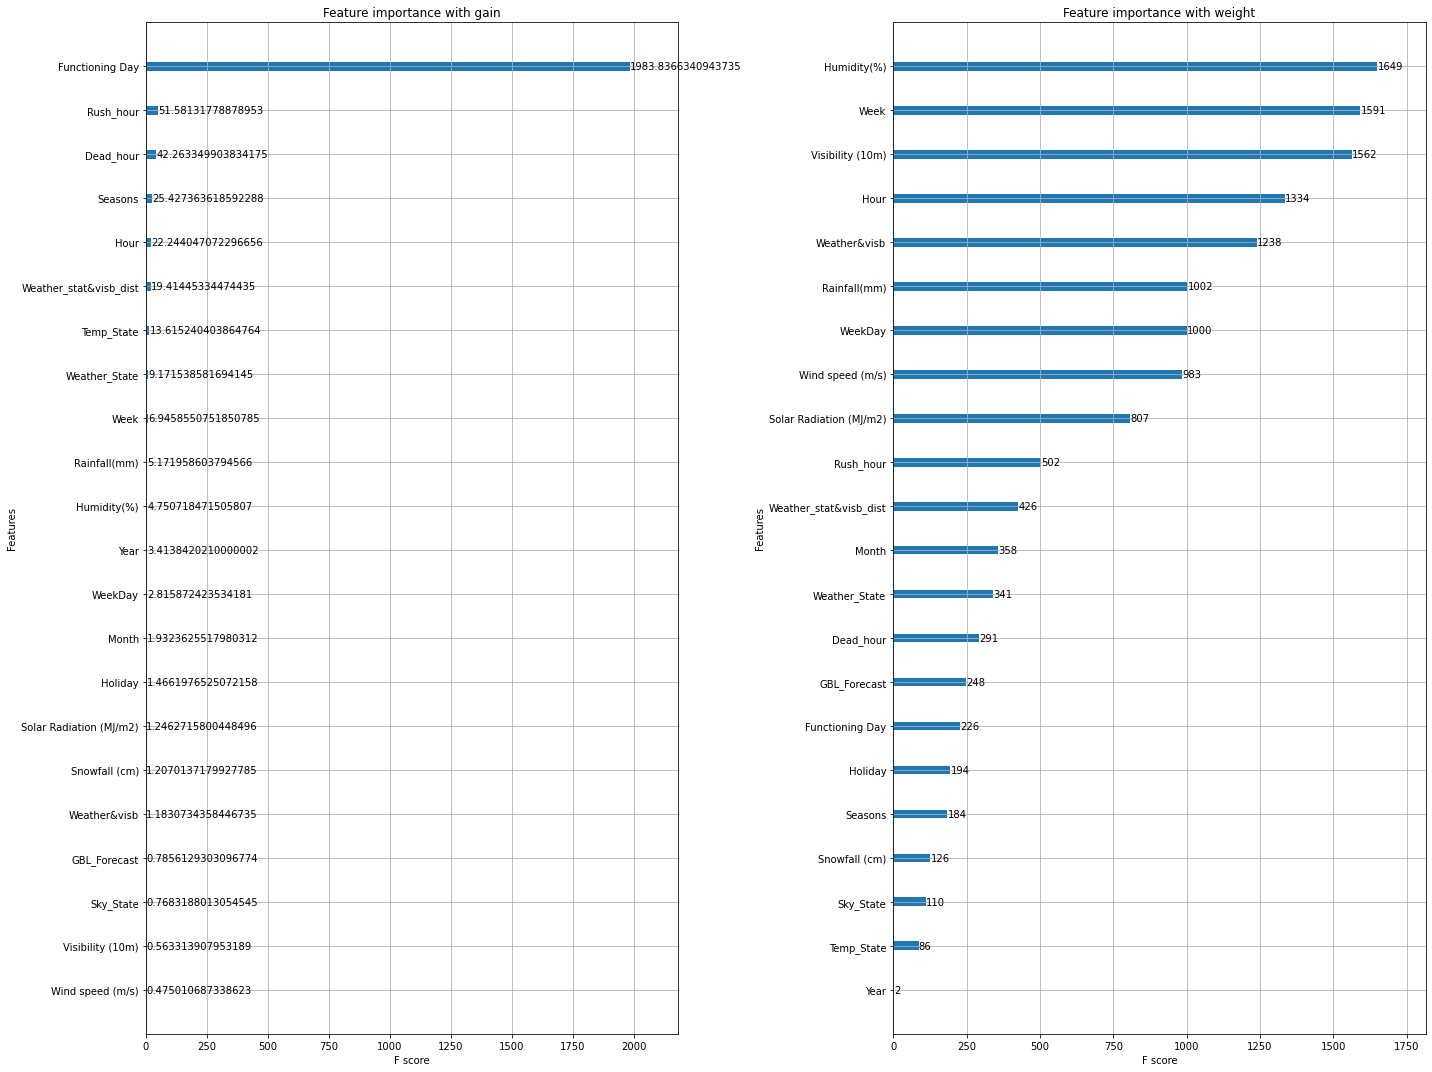

In [274]:
fig = plt.figure(figsize=(20, 15))
# Adds subplot on position 1
ax1 = fig.add_subplot(121)
#is the average gain of splits which use the feature
xgb.plot_importance(XGB, importance_type  = "gain"
                    ,ax = ax1, title = f'average gain') 
ax2= fig.add_subplot(122)
#”weight” is the number of times a feature appears in a tree
xgb.plot_importance(XGB, importance_type  = "weight"
                    ,ax = ax2, title = f'number of times a feature appears')
fig.tight_layout()
plt.show()

In [179]:
# from sklearn.model_selection import cross_val_score
# kfold = KFold(n_splits=5)
# cv_score = cross_val_score(XGB,X_train, y_train,n_jobs=4,verbose = 1,cv=kfold,scoring=rmsle_scorer)
# print(f'cv_error : {-cv_score.mean()}')

---
<a id='GBRegressor_train'></a>
## GBRegressor
### [Jump Top](#Jump)

In [180]:
prev_trainGBR = 0
prev_testGBR = 0

In [181]:
#GBR learn_rate = 0.05 , n_est = 1000 

#GBR = GradientBoostingRegressor(random_state =0,loss='ls',
#    n_estimators=9000,subsample=0.84,min_samples_leaf = 0.00001
#    ,max_features=0.83,learning_rate=0.01
#    ,verbose =0, criterion='friedman_mse')

GBR = GradientBoostingRegressor(random_state =0,loss='ls',
    n_estimators=2500,subsample=0.8,min_samples_leaf = 0.0001
    ,max_features=0.9,learning_rate=0.04
    ,verbose =0, criterion='friedman_mse')


GBR.fit(X_train, y_train)

y_pred_trainGBR = GBR.predict(X_train)  
y_pred_testGBR = GBR.predict(X_test)  


rmsle_trainGBR =  rmsle(y_train, y_pred_trainGBR, True)
rmsle_testGBR  = rmsle(y_test, y_pred_testGBR, True)

print('(Train)  GBR  RMSLE:',rmsle_trainGBR )
print('(Test) GBR RMSLE:',rmsle_testGBR  )
print('---------------------------------' )
print('(Train) Prev RMSLE:', prev_trainGBR)
print('(Test) Prev RMSLE:', prev_testGBR)
prev_trainGBR = rmsle_trainGBR
prev_testGBR = rmsle_testGBR 
print('---------------------------------' )
print("Training Score:", r2_score(y_train, y_pred_trainGBR) * 100,' %')
print("Test Score:", r2_score(y_test, y_pred_testGBR) * 100,' %')

(Train)  GBR  RMSLE: 0.14703934356099588
(Test) GBR RMSLE: 0.29662783776232565
---------------------------------
(Train) Prev RMSLE: 0
(Test) Prev RMSLE: 0
---------------------------------
Training Score: 99.83347736564934  %
Test Score: 99.43059349030118  %


In [182]:
# GBR_Full_predict()

In [183]:
# GBR_Full_predict()

In [184]:
# GBR_Full_predict()

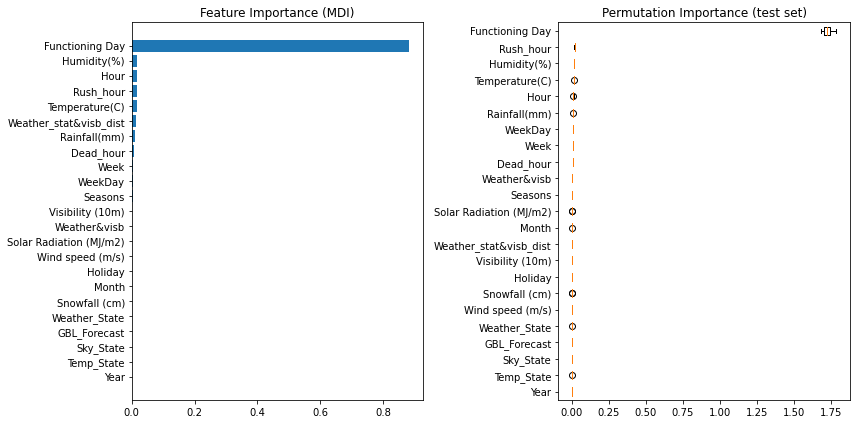

In [185]:
feature_importance = GBR.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
feature_names = list(X_train.columns.values)
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(GBR, X_test, y_test, n_repeats=5,
                                random_state=42, n_jobs=4)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

---
### Grid Search is marked down - My CPU :( 

In [186]:
# n_estimators = [800,900,1000,1100,1200]
# learning_rate = np.arange(0.001,0.05,0.005).tolist()
# # Maximum depth of trees
# max_depth = [4,5,6,7,8]

# # Child weight
# min_child_weight= [6, 8, 10]

# # HYperparameter Grid
# param_dict = {'n_estimators' : [1000],
#               'max_depth' : [4],
#               'learning_rate': learning_rate }

# grid = GridSearchCV(estimator = GBR,
#                        param_grid = param_dict,n_jobs=1,
#                        cv = 2, verbose=3, scoring = rmsle_scorer)

# grid.fit(X_train, y_train)
# grid.best_params_
# optimal_model = grid.best_estimator_

---

<a id='CatBoosttrain'></a>

## CatBoost 
### [Jump Top](#Jump)

In [187]:
train_dataset = cb.Pool(CAT_train, y_train) 
test_dataset = cb.Pool(CAT_test, y_test)
#grid = {'depth': [4], 'iterations': [2000], 'l2_leaf_reg': [1], 'learning_rate': [0.05]} #0.42222
#grid = {'depth': [3],'iterations': [2020], 'l2_leaf_reg': [2], 'learning_rate': [0.069]} ##0.4229364603151052
model = cb.CatBoostRegressor(loss_function='RMSE',random_state=0)
grid = {'max_depth': [3],'iterations': [2020], 'l2_leaf_reg': [2], 'learning_rate': [0.069],'subsample': [0.8]} ##0.4229364603151052

model.grid_search(grid, train_dataset)
pred_test = model.predict(CAT_test)
pred_train=model.predict(CAT_train)
# rmse= (np.sqrt(mean_squared_error(y_test, pred_test)))
# r2 = r2_score(y_test, pred_test)
print('(Test) CatBoost Regression RMSLE:', rmsle(y_test, pred_test, True))
print('(Train) CatBoost Regression RMSLE:', rmsle(y_train, pred_train, True))

0:	learn: 6.0896521	test: 6.0112366	best: 6.0112366 (0)	total: 146ms	remaining: 4m 54s
1:	learn: 5.6849465	test: 5.6097237	best: 5.6097237 (1)	total: 147ms	remaining: 2m 28s
2:	learn: 5.3069695	test: 5.2349958	best: 5.2349958 (2)	total: 148ms	remaining: 1m 39s
3:	learn: 4.9570228	test: 4.8881008	best: 4.8881008 (3)	total: 149ms	remaining: 1m 15s
4:	learn: 4.6305990	test: 4.5648880	best: 4.5648880 (4)	total: 150ms	remaining: 1m
5:	learn: 4.3301002	test: 4.2683865	best: 4.2683865 (5)	total: 151ms	remaining: 50.8s
6:	learn: 4.0503225	test: 3.9907859	best: 3.9907859 (6)	total: 152ms	remaining: 43.8s
7:	learn: 3.7884738	test: 3.7325683	best: 3.7325683 (7)	total: 154ms	remaining: 38.6s
8:	learn: 3.5449433	test: 3.4905972	best: 3.4905972 (8)	total: 155ms	remaining: 34.6s
9:	learn: 3.3178562	test: 3.2651862	best: 3.2651862 (9)	total: 156ms	remaining: 31.4s
10:	learn: 3.1090817	test: 3.0592295	best: 3.0592295 (10)	total: 157ms	remaining: 28.7s
11:	learn: 2.9184269	test: 2.8705573	best: 2.870557

132:	learn: 0.4502991	test: 0.4629353	best: 0.4629353 (132)	total: 303ms	remaining: 4.3s
133:	learn: 0.4492389	test: 0.4616130	best: 0.4616130 (133)	total: 305ms	remaining: 4.29s
134:	learn: 0.4484854	test: 0.4607388	best: 0.4607388 (134)	total: 306ms	remaining: 4.27s
135:	learn: 0.4479940	test: 0.4600561	best: 0.4600561 (135)	total: 307ms	remaining: 4.25s
136:	learn: 0.4472961	test: 0.4589109	best: 0.4589109 (136)	total: 308ms	remaining: 4.23s
137:	learn: 0.4465140	test: 0.4584472	best: 0.4584472 (137)	total: 309ms	remaining: 4.22s
138:	learn: 0.4460025	test: 0.4579488	best: 0.4579488 (138)	total: 310ms	remaining: 4.2s
139:	learn: 0.4455503	test: 0.4578417	best: 0.4578417 (139)	total: 311ms	remaining: 4.18s
140:	learn: 0.4444580	test: 0.4568384	best: 0.4568384 (140)	total: 313ms	remaining: 4.17s
141:	learn: 0.4438560	test: 0.4565815	best: 0.4565815 (141)	total: 314ms	remaining: 4.15s
142:	learn: 0.4432204	test: 0.4558893	best: 0.4558893 (142)	total: 315ms	remaining: 4.13s
143:	learn: 

270:	learn: 0.3810375	test: 0.4046110	best: 0.4046110 (270)	total: 463ms	remaining: 2.99s
271:	learn: 0.3806501	test: 0.4044951	best: 0.4044951 (271)	total: 464ms	remaining: 2.98s
272:	learn: 0.3805457	test: 0.4044480	best: 0.4044480 (272)	total: 465ms	remaining: 2.98s
273:	learn: 0.3801029	test: 0.4037929	best: 0.4037929 (273)	total: 466ms	remaining: 2.97s
274:	learn: 0.3797287	test: 0.4035421	best: 0.4035421 (274)	total: 468ms	remaining: 2.97s
275:	learn: 0.3796386	test: 0.4034756	best: 0.4034756 (275)	total: 469ms	remaining: 2.96s
276:	learn: 0.3791748	test: 0.4032104	best: 0.4032104 (276)	total: 470ms	remaining: 2.96s
277:	learn: 0.3788756	test: 0.4028730	best: 0.4028730 (277)	total: 471ms	remaining: 2.95s
278:	learn: 0.3785375	test: 0.4027190	best: 0.4027190 (278)	total: 472ms	remaining: 2.95s
279:	learn: 0.3782363	test: 0.4023682	best: 0.4023682 (279)	total: 473ms	remaining: 2.94s
280:	learn: 0.3779418	test: 0.4019487	best: 0.4019487 (280)	total: 474ms	remaining: 2.94s
281:	learn

410:	learn: 0.3433730	test: 0.3796608	best: 0.3796608 (410)	total: 623ms	remaining: 2.44s
411:	learn: 0.3432590	test: 0.3795072	best: 0.3795072 (411)	total: 624ms	remaining: 2.44s
412:	learn: 0.3430245	test: 0.3793183	best: 0.3793183 (412)	total: 625ms	remaining: 2.43s
413:	learn: 0.3426908	test: 0.3793491	best: 0.3793183 (412)	total: 627ms	remaining: 2.43s
414:	learn: 0.3424487	test: 0.3790025	best: 0.3790025 (414)	total: 628ms	remaining: 2.43s
415:	learn: 0.3423516	test: 0.3790093	best: 0.3790025 (414)	total: 629ms	remaining: 2.42s
416:	learn: 0.3420309	test: 0.3789104	best: 0.3789104 (416)	total: 630ms	remaining: 2.42s
417:	learn: 0.3418733	test: 0.3789352	best: 0.3789104 (416)	total: 631ms	remaining: 2.42s
418:	learn: 0.3416262	test: 0.3788982	best: 0.3788982 (418)	total: 632ms	remaining: 2.42s
419:	learn: 0.3412373	test: 0.3785705	best: 0.3785705 (419)	total: 633ms	remaining: 2.41s
420:	learn: 0.3407445	test: 0.3778990	best: 0.3778990 (420)	total: 634ms	remaining: 2.41s
421:	learn

550:	learn: 0.3140236	test: 0.3662827	best: 0.3661820 (548)	total: 783ms	remaining: 2.09s
551:	learn: 0.3137423	test: 0.3664151	best: 0.3661820 (548)	total: 785ms	remaining: 2.09s
552:	learn: 0.3136028	test: 0.3661995	best: 0.3661820 (548)	total: 786ms	remaining: 2.08s
553:	learn: 0.3135264	test: 0.3662861	best: 0.3661820 (548)	total: 787ms	remaining: 2.08s
554:	learn: 0.3134012	test: 0.3662788	best: 0.3661820 (548)	total: 788ms	remaining: 2.08s
555:	learn: 0.3132885	test: 0.3664473	best: 0.3661820 (548)	total: 789ms	remaining: 2.08s
556:	learn: 0.3131262	test: 0.3662981	best: 0.3661820 (548)	total: 790ms	remaining: 2.08s
557:	learn: 0.3129984	test: 0.3662316	best: 0.3661820 (548)	total: 792ms	remaining: 2.07s
558:	learn: 0.3129234	test: 0.3662080	best: 0.3661820 (548)	total: 793ms	remaining: 2.07s
559:	learn: 0.3126543	test: 0.3664621	best: 0.3661820 (548)	total: 794ms	remaining: 2.07s
560:	learn: 0.3125306	test: 0.3663550	best: 0.3661820 (548)	total: 795ms	remaining: 2.07s
561:	learn

689:	learn: 0.2939457	test: 0.3554647	best: 0.3553075 (685)	total: 945ms	remaining: 1.82s
690:	learn: 0.2939224	test: 0.3554603	best: 0.3553075 (685)	total: 946ms	remaining: 1.82s
691:	learn: 0.2937950	test: 0.3557214	best: 0.3553075 (685)	total: 947ms	remaining: 1.82s
692:	learn: 0.2937029	test: 0.3556813	best: 0.3553075 (685)	total: 948ms	remaining: 1.82s
693:	learn: 0.2934954	test: 0.3555035	best: 0.3553075 (685)	total: 950ms	remaining: 1.81s
694:	learn: 0.2934101	test: 0.3555898	best: 0.3553075 (685)	total: 951ms	remaining: 1.81s
695:	learn: 0.2933624	test: 0.3556103	best: 0.3553075 (685)	total: 952ms	remaining: 1.81s
696:	learn: 0.2932191	test: 0.3556458	best: 0.3553075 (685)	total: 953ms	remaining: 1.81s
697:	learn: 0.2930277	test: 0.3556504	best: 0.3553075 (685)	total: 954ms	remaining: 1.81s
698:	learn: 0.2929162	test: 0.3557583	best: 0.3553075 (685)	total: 955ms	remaining: 1.8s
699:	learn: 0.2926903	test: 0.3556953	best: 0.3553075 (685)	total: 957ms	remaining: 1.8s
700:	learn: 

828:	learn: 0.2745711	test: 0.3446257	best: 0.3446257 (828)	total: 1.1s	remaining: 1.59s
829:	learn: 0.2744348	test: 0.3445332	best: 0.3445332 (829)	total: 1.1s	remaining: 1.58s
830:	learn: 0.2742448	test: 0.3444462	best: 0.3444462 (830)	total: 1.11s	remaining: 1.58s
831:	learn: 0.2741178	test: 0.3444384	best: 0.3444384 (831)	total: 1.11s	remaining: 1.58s
832:	learn: 0.2739751	test: 0.3442577	best: 0.3442577 (832)	total: 1.11s	remaining: 1.58s
833:	learn: 0.2738719	test: 0.3440663	best: 0.3440663 (833)	total: 1.11s	remaining: 1.58s
834:	learn: 0.2736245	test: 0.3436205	best: 0.3436205 (834)	total: 1.11s	remaining: 1.58s
835:	learn: 0.2735155	test: 0.3435068	best: 0.3435068 (835)	total: 1.11s	remaining: 1.58s
836:	learn: 0.2732658	test: 0.3435242	best: 0.3435068 (835)	total: 1.11s	remaining: 1.57s
837:	learn: 0.2730656	test: 0.3435465	best: 0.3435068 (835)	total: 1.11s	remaining: 1.57s
838:	learn: 0.2729582	test: 0.3434257	best: 0.3434257 (838)	total: 1.12s	remaining: 1.57s
839:	learn: 

952:	learn: 0.2620761	test: 0.3386243	best: 0.3385316 (948)	total: 1.26s	remaining: 1.41s
953:	learn: 0.2619993	test: 0.3384767	best: 0.3384767 (953)	total: 1.26s	remaining: 1.41s
954:	learn: 0.2619172	test: 0.3383504	best: 0.3383504 (954)	total: 1.26s	remaining: 1.41s
955:	learn: 0.2618243	test: 0.3383849	best: 0.3383504 (954)	total: 1.26s	remaining: 1.41s
956:	learn: 0.2615824	test: 0.3381060	best: 0.3381060 (956)	total: 1.27s	remaining: 1.41s
957:	learn: 0.2614940	test: 0.3381207	best: 0.3381060 (956)	total: 1.27s	remaining: 1.4s
958:	learn: 0.2614254	test: 0.3379938	best: 0.3379938 (958)	total: 1.27s	remaining: 1.4s
959:	learn: 0.2612920	test: 0.3383217	best: 0.3379938 (958)	total: 1.27s	remaining: 1.4s
960:	learn: 0.2612212	test: 0.3382879	best: 0.3379938 (958)	total: 1.27s	remaining: 1.4s
961:	learn: 0.2611230	test: 0.3383152	best: 0.3379938 (958)	total: 1.27s	remaining: 1.4s
962:	learn: 0.2610185	test: 0.3383929	best: 0.3379938 (958)	total: 1.27s	remaining: 1.4s
963:	learn: 0.26

1077:	learn: 0.2502213	test: 0.3347784	best: 0.3347784 (1077)	total: 1.42s	remaining: 1.24s
1078:	learn: 0.2501358	test: 0.3346885	best: 0.3346885 (1078)	total: 1.42s	remaining: 1.24s
1079:	learn: 0.2500136	test: 0.3347213	best: 0.3346885 (1078)	total: 1.42s	remaining: 1.24s
1080:	learn: 0.2499799	test: 0.3347673	best: 0.3346885 (1078)	total: 1.42s	remaining: 1.23s
1081:	learn: 0.2499716	test: 0.3348101	best: 0.3346885 (1078)	total: 1.42s	remaining: 1.23s
1082:	learn: 0.2499404	test: 0.3348049	best: 0.3346885 (1078)	total: 1.42s	remaining: 1.23s
1083:	learn: 0.2498848	test: 0.3347295	best: 0.3346885 (1078)	total: 1.42s	remaining: 1.23s
1084:	learn: 0.2497796	test: 0.3347207	best: 0.3346885 (1078)	total: 1.43s	remaining: 1.23s
1085:	learn: 0.2497292	test: 0.3347089	best: 0.3346885 (1078)	total: 1.43s	remaining: 1.23s
1086:	learn: 0.2496411	test: 0.3346175	best: 0.3346175 (1086)	total: 1.43s	remaining: 1.23s
1087:	learn: 0.2494760	test: 0.3346644	best: 0.3346175 (1086)	total: 1.43s	remai

1206:	learn: 0.2404368	test: 0.3318661	best: 0.3316196 (1200)	total: 1.57s	remaining: 1.06s
1207:	learn: 0.2403940	test: 0.3318228	best: 0.3316196 (1200)	total: 1.58s	remaining: 1.06s
1208:	learn: 0.2403914	test: 0.3318373	best: 0.3316196 (1200)	total: 1.58s	remaining: 1.06s
1209:	learn: 0.2403879	test: 0.3318353	best: 0.3316196 (1200)	total: 1.58s	remaining: 1.06s
1210:	learn: 0.2403112	test: 0.3318934	best: 0.3316196 (1200)	total: 1.58s	remaining: 1.05s
1211:	learn: 0.2402207	test: 0.3320016	best: 0.3316196 (1200)	total: 1.58s	remaining: 1.05s
1212:	learn: 0.2401758	test: 0.3319968	best: 0.3316196 (1200)	total: 1.58s	remaining: 1.05s
1213:	learn: 0.2400311	test: 0.3320350	best: 0.3316196 (1200)	total: 1.58s	remaining: 1.05s
1214:	learn: 0.2399086	test: 0.3320773	best: 0.3316196 (1200)	total: 1.58s	remaining: 1.05s
1215:	learn: 0.2396697	test: 0.3320730	best: 0.3316196 (1200)	total: 1.58s	remaining: 1.05s
1216:	learn: 0.2396275	test: 0.3320623	best: 0.3316196 (1200)	total: 1.59s	remai

1341:	learn: 0.2298659	test: 0.3283153	best: 0.3281881 (1335)	total: 1.73s	remaining: 876ms
1342:	learn: 0.2298180	test: 0.3283273	best: 0.3281881 (1335)	total: 1.74s	remaining: 875ms
1343:	learn: 0.2297427	test: 0.3285654	best: 0.3281881 (1335)	total: 1.74s	remaining: 874ms
1344:	learn: 0.2297279	test: 0.3285366	best: 0.3281881 (1335)	total: 1.74s	remaining: 872ms
1345:	learn: 0.2297041	test: 0.3285355	best: 0.3281881 (1335)	total: 1.74s	remaining: 871ms
1346:	learn: 0.2296914	test: 0.3285479	best: 0.3281881 (1335)	total: 1.74s	remaining: 870ms
1347:	learn: 0.2295801	test: 0.3285751	best: 0.3281881 (1335)	total: 1.74s	remaining: 868ms
1348:	learn: 0.2293459	test: 0.3285597	best: 0.3281881 (1335)	total: 1.74s	remaining: 867ms
1349:	learn: 0.2293017	test: 0.3285020	best: 0.3281881 (1335)	total: 1.74s	remaining: 866ms
1350:	learn: 0.2292088	test: 0.3284749	best: 0.3281881 (1335)	total: 1.75s	remaining: 864ms
1351:	learn: 0.2291542	test: 0.3284024	best: 0.3281881 (1335)	total: 1.75s	remai

1471:	learn: 0.2221114	test: 0.3255841	best: 0.3255804 (1468)	total: 1.89s	remaining: 705ms
1472:	learn: 0.2220854	test: 0.3255737	best: 0.3255737 (1472)	total: 1.9s	remaining: 704ms
1473:	learn: 0.2219884	test: 0.3256062	best: 0.3255737 (1472)	total: 1.9s	remaining: 702ms
1474:	learn: 0.2219570	test: 0.3255459	best: 0.3255459 (1474)	total: 1.9s	remaining: 701ms
1475:	learn: 0.2216814	test: 0.3251458	best: 0.3251458 (1475)	total: 1.9s	remaining: 700ms
1476:	learn: 0.2216198	test: 0.3251854	best: 0.3251458 (1475)	total: 1.9s	remaining: 699ms
1477:	learn: 0.2215389	test: 0.3251693	best: 0.3251458 (1475)	total: 1.9s	remaining: 697ms
1478:	learn: 0.2215158	test: 0.3251512	best: 0.3251458 (1475)	total: 1.9s	remaining: 696ms
1479:	learn: 0.2214664	test: 0.3251399	best: 0.3251399 (1479)	total: 1.9s	remaining: 695ms
1480:	learn: 0.2214273	test: 0.3251515	best: 0.3251399 (1479)	total: 1.9s	remaining: 693ms
1481:	learn: 0.2212401	test: 0.3251225	best: 0.3251225 (1481)	total: 1.91s	remaining: 692

1597:	learn: 0.2144940	test: 0.3239843	best: 0.3239831 (1596)	total: 2.05s	remaining: 542ms
1598:	learn: 0.2144161	test: 0.3239061	best: 0.3239061 (1598)	total: 2.05s	remaining: 540ms
1599:	learn: 0.2143379	test: 0.3239372	best: 0.3239061 (1598)	total: 2.05s	remaining: 539ms
1600:	learn: 0.2143281	test: 0.3239127	best: 0.3239061 (1598)	total: 2.05s	remaining: 538ms
1601:	learn: 0.2142356	test: 0.3238880	best: 0.3238880 (1601)	total: 2.06s	remaining: 536ms
1602:	learn: 0.2142128	test: 0.3238803	best: 0.3238803 (1602)	total: 2.06s	remaining: 535ms
1603:	learn: 0.2139512	test: 0.3238662	best: 0.3238662 (1603)	total: 2.06s	remaining: 534ms
1604:	learn: 0.2139045	test: 0.3238783	best: 0.3238662 (1603)	total: 2.06s	remaining: 533ms
1605:	learn: 0.2138043	test: 0.3238202	best: 0.3238202 (1605)	total: 2.06s	remaining: 531ms
1606:	learn: 0.2137536	test: 0.3237937	best: 0.3237937 (1606)	total: 2.06s	remaining: 530ms
1607:	learn: 0.2137400	test: 0.3237975	best: 0.3237937 (1606)	total: 2.06s	remai

1730:	learn: 0.2069823	test: 0.3231479	best: 0.3227720 (1706)	total: 2.21s	remaining: 369ms
1731:	learn: 0.2069585	test: 0.3231621	best: 0.3227720 (1706)	total: 2.21s	remaining: 368ms
1732:	learn: 0.2069242	test: 0.3231613	best: 0.3227720 (1706)	total: 2.21s	remaining: 366ms
1733:	learn: 0.2068535	test: 0.3230744	best: 0.3227720 (1706)	total: 2.21s	remaining: 365ms
1734:	learn: 0.2068389	test: 0.3230995	best: 0.3227720 (1706)	total: 2.21s	remaining: 364ms
1735:	learn: 0.2067874	test: 0.3230567	best: 0.3227720 (1706)	total: 2.22s	remaining: 363ms
1736:	learn: 0.2067773	test: 0.3230534	best: 0.3227720 (1706)	total: 2.22s	remaining: 361ms
1737:	learn: 0.2067368	test: 0.3230597	best: 0.3227720 (1706)	total: 2.22s	remaining: 360ms
1738:	learn: 0.2067142	test: 0.3230523	best: 0.3227720 (1706)	total: 2.22s	remaining: 359ms
1739:	learn: 0.2066969	test: 0.3230522	best: 0.3227720 (1706)	total: 2.22s	remaining: 357ms
1740:	learn: 0.2066678	test: 0.3230388	best: 0.3227720 (1706)	total: 2.22s	remai

1864:	learn: 0.2001811	test: 0.3219850	best: 0.3219006 (1851)	total: 2.37s	remaining: 197ms
1865:	learn: 0.2001649	test: 0.3219799	best: 0.3219006 (1851)	total: 2.37s	remaining: 196ms
1866:	learn: 0.2000685	test: 0.3219757	best: 0.3219006 (1851)	total: 2.37s	remaining: 194ms
1867:	learn: 0.2000509	test: 0.3219676	best: 0.3219006 (1851)	total: 2.37s	remaining: 193ms
1868:	learn: 0.1999983	test: 0.3219300	best: 0.3219006 (1851)	total: 2.37s	remaining: 192ms
1869:	learn: 0.1999480	test: 0.3219454	best: 0.3219006 (1851)	total: 2.38s	remaining: 191ms
1870:	learn: 0.1999012	test: 0.3219426	best: 0.3219006 (1851)	total: 2.38s	remaining: 189ms
1871:	learn: 0.1998755	test: 0.3219422	best: 0.3219006 (1851)	total: 2.38s	remaining: 188ms
1872:	learn: 0.1998491	test: 0.3219470	best: 0.3219006 (1851)	total: 2.38s	remaining: 187ms
1873:	learn: 0.1998235	test: 0.3219442	best: 0.3219006 (1851)	total: 2.38s	remaining: 185ms
1874:	learn: 0.1997587	test: 0.3219635	best: 0.3219006 (1851)	total: 2.38s	remai

1996:	learn: 0.1945102	test: 0.3203190	best: 0.3203190 (1996)	total: 2.53s	remaining: 29.1ms
1997:	learn: 0.1944879	test: 0.3203112	best: 0.3203112 (1997)	total: 2.53s	remaining: 27.9ms
1998:	learn: 0.1944865	test: 0.3203230	best: 0.3203112 (1997)	total: 2.53s	remaining: 26.6ms
1999:	learn: 0.1943733	test: 0.3203448	best: 0.3203112 (1997)	total: 2.53s	remaining: 25.3ms
2000:	learn: 0.1943587	test: 0.3203585	best: 0.3203112 (1997)	total: 2.53s	remaining: 24.1ms
2001:	learn: 0.1943259	test: 0.3203577	best: 0.3203112 (1997)	total: 2.54s	remaining: 22.8ms
2002:	learn: 0.1942860	test: 0.3203735	best: 0.3203112 (1997)	total: 2.54s	remaining: 21.5ms
2003:	learn: 0.1942200	test: 0.3203718	best: 0.3203112 (1997)	total: 2.54s	remaining: 20.3ms
2004:	learn: 0.1941709	test: 0.3204050	best: 0.3203112 (1997)	total: 2.54s	remaining: 19ms
2005:	learn: 0.1941221	test: 0.3203555	best: 0.3203112 (1997)	total: 2.54s	remaining: 17.7ms
2006:	learn: 0.1940986	test: 0.3203547	best: 0.3203112 (1997)	total: 2.5

327:	learn: 0.3566709	test: 0.4037870	best: 0.4037870 (327)
328:	learn: 0.3563420	test: 0.4037680	best: 0.4037680 (328)
329:	learn: 0.3560295	test: 0.4036179	best: 0.4036179 (329)
330:	learn: 0.3558555	test: 0.4034775	best: 0.4034775 (330)
331:	learn: 0.3556366	test: 0.4033308	best: 0.4033308 (331)
332:	learn: 0.3553396	test: 0.4032176	best: 0.4032176 (332)
333:	learn: 0.3550524	test: 0.4030050	best: 0.4030050 (333)
334:	learn: 0.3546643	test: 0.4027160	best: 0.4027160 (334)
335:	learn: 0.3543574	test: 0.4025398	best: 0.4025398 (335)
336:	learn: 0.3540352	test: 0.4024257	best: 0.4024257 (336)
337:	learn: 0.3537349	test: 0.4022702	best: 0.4022702 (337)
338:	learn: 0.3533633	test: 0.4020685	best: 0.4020685 (338)
339:	learn: 0.3530630	test: 0.4019965	best: 0.4019965 (339)
340:	learn: 0.3528785	test: 0.4018885	best: 0.4018885 (340)
341:	learn: 0.3525394	test: 0.4018919	best: 0.4018885 (340)
342:	learn: 0.3522280	test: 0.4017006	best: 0.4017006 (342)
343:	learn: 0.3518328	test: 0.4013920	be

830:	learn: 0.2645907	test: 0.3660149	best: 0.3660149 (830)
831:	learn: 0.2644449	test: 0.3660859	best: 0.3660149 (830)
832:	learn: 0.2642743	test: 0.3660377	best: 0.3660149 (830)
833:	learn: 0.2641735	test: 0.3660301	best: 0.3660149 (830)
834:	learn: 0.2640723	test: 0.3660035	best: 0.3660035 (834)
835:	learn: 0.2639785	test: 0.3660167	best: 0.3660035 (834)
836:	learn: 0.2638487	test: 0.3659670	best: 0.3659670 (836)
837:	learn: 0.2637065	test: 0.3659406	best: 0.3659406 (837)
838:	learn: 0.2635881	test: 0.3659246	best: 0.3659246 (838)
839:	learn: 0.2634850	test: 0.3659087	best: 0.3659087 (839)
840:	learn: 0.2634181	test: 0.3658782	best: 0.3658782 (840)
841:	learn: 0.2632709	test: 0.3657798	best: 0.3657798 (841)
842:	learn: 0.2631283	test: 0.3656912	best: 0.3656912 (842)
843:	learn: 0.2629847	test: 0.3656533	best: 0.3656533 (843)
844:	learn: 0.2628830	test: 0.3656017	best: 0.3656017 (844)
845:	learn: 0.2628021	test: 0.3655787	best: 0.3655787 (845)
846:	learn: 0.2627172	test: 0.3655636	be

KeyboardInterrupt: 

In [ ]:
# #_init first avoid error
# Catboost_Full_predict()   

In [ ]:
# #_init first avoid error
# Catboost_Full_predict() 

In [ ]:
# #_init first avoid error
# Catboost_Full_predict() 

In [ ]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

<a id='bagging_test'></a>
## bagging
### [Jump Top](#Jump)

<a id='Stacking_train'></a>
## Stacking !
### [Jump Top](#Jump)

In [ ]:
from mlxtend.regressor import StackingRegressor

In [ ]:
st_regr = StackingRegressor(regressors=[model,GBR,XGB], meta_regressor=rand_model)
st_regr.fit(X_train, y_train)
st_regr_train_pred = st_regr.predict(X_train)
pred_test = st_regr.predict(X_test)
pred_train=st_regr.predict(X_train)
print('(Test) Stacking Regression RMSLE:', rmsle(y_test, pred_test, True))
print('(Train) Stacking Regression RMSLE:', rmsle(y_train, pred_train, True))
# print(rmsle(y_train, st_regr_train_pred))
# print(mean_absolute_error(y_train, st_regr_train_pred))

In [ ]:
Xtest = test[selected_features]

predsXGB = st_regr.predict(Xtest)
preds_expXGB = np.exp(predsXGB)

print('(Full Test) XGB RMSLE:', rmsle(full_test.y, preds_expXGB, False))
print("(Full Test) XGB R2 Score:", r2_score(full_test.y, preds_expXGB) * 100,' %')

---
<a id='Submission_Preparation'></a>
### Submission Preparation
### [Jump Top](#Jump)

In [ ]:
full_test_path = r"D:\AI\1-Technical_ITI\02-Phase_2\projects\P1\SeoulBikeDataTestFull.csv"

In [ ]:
full_test = pd.read_csv(full_test_path)

In [ ]:
test = df_test.copy()

In [ ]:
test['Year'] = df_test['Date'].dt.year.astype('int')
test['Week'] = df_test['Date'].dt.isocalendar().week.astype('int')
test['Month'] = df_test['Date'].dt.month.astype('int') 
test['WeekDay'] = df_test['Date'].dt.weekday.astype('int')

In [ ]:
#test.y.value_counts()

In [ ]:
test.columns

## Test Data Procc

In [ ]:
map_data_series(test,'Functioning Day',['Yes','No'],[1,0])

In [ ]:
map_data_series(test,'Holiday',['Holiday','No Holiday'],[1,0])

In [ ]:
map_data_series(test,'Seasons',['Winter','Spring','Summer','Autumn'],[0,1,2,3])

In [ ]:
new_feature_data_series(test,['Hour','Functioning Day'],dead_hour_grad_2,'Dead_hour')
new_feature_data_series(test,['Hour','Functioning Day'],rush_hour_grad,'Rush_hour')

In [ ]:
new_feature_data_series(test,['Hour'],day_night,'day_night')
new_feature_data_series(test,['Humidity(%)'],lambda df : 0 if (df['Humidity(%)'] <= 70) else 1,'Humidity_high')
new_feature_data_series(test,['Temperature(C)'],lambda df : 0 if (df['Temperature(C)'] <= 35) else 1,'Temperature_high')

In [ ]:
new_feature_data_series(test,['Humidity(%)','Temperature(C)','Solar Radiation (MJ/m2)'],lambda df : 0 if (df['Temperature(C)'] < 35) and (df['Humidity(%)'] < 70) and (df['Solar Radiation (MJ/m2)'] < 1.4) else 1,'Weather_bad')

In [ ]:
test['Ideal'] = df_test[['Temperature(C)', 'Wind speed (m/s)']] \
    .apply(lambda df: 1 if (df['Temperature(C)'] < 30 and df['Wind speed (m/s)'] < 2.8) else 0, axis = 1)

In [ ]:
#new_feature_data_series(test,['Temperature(C)','Humidity(%)','Functioning Day'],feels_like,'Feels_like')
new_feature_data_series(test,['Temperature(C)','Dew point temperature(C)','Functioning Day'],humidex,'Humidex')

In [ ]:
new_feature_data_series(test,['Visibility (10m)'],visibility,'Visibility_cat')

In [ ]:
new_feature_data_series(test,['Rainfall(mm)'],rain_fall,'Rain_cat')

In [ ]:
new_feature_data_series(test,['Snowfall (cm)'],snow_fall,'Snow_cat')

In [ ]:
test['Weather_State'] =test[['Temperature(C)', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: "Sunny_hot" if Sunny_Hot(df)\
           else "Clear_hot" if Clear_hot(df)\
           else "PCloudy_hot" if PCloudy_hot(df)\
           else "Cloudy_hot" if Cloudy_hot(df)\
           else "Rain_hot" if Rain_hot(df)\
           else "Night_hot" if Night_hot(df)\
           else "Sunny_Warm" if Sunny_Warm(df)\
           else "Clear_Warm" if Clear_Warm(df)\
           else "PCloudy_Warm" if PCloudy_Warm(df)\
           else "Cloudy_Warm" if Cloudy_Warm(df)\
           else "Rain_Warm" if Rain_Warm(df)\
           else "Night_Warm" if Night_Warm(df)\
           else "Sunny_Cold" if Sunny_Cold(df)\
           else "Clear_Cold" if Clear_Cold(df)\
           else "PCloudy_Cold" if PCloudy_Cold(df)\
           else "Cloudy_Cold" if Cloudy_Cold(df)\
           else "Rain_Cold" if Rain_Cold(df)\
           else "Snow_Cold" if Snow_Cold(df)\
           else "Night_Cold" if Night_Cold(df)\
           else "Sunny_Freezing" if Sunny_Freezing(df)\
           else "Clear_Freezing" if Clear_Freezing(df)\
           else "PCloudy_Freezing" if PCloudy_Freezing(df)\
           else "Cloudy_Freezing" if Cloudy_Freezing(df)\
           else "Rain_Freezing" if Rain_Freezing(df)\
           else "Snow_Freezing" if Snow_Freezing(df)\
           else "Night_Freezing" if Night_Freezing(df)\
           else "Rain&Snow" if Rain_Snow(df)\
           else 0, axis = 1)

In [ ]:
map_data_series(test,'Weather_State',Weather_Description_list,Weather_Description_neumeric)

In [ ]:
test["Date_tmp"] = test['Date'].dt.to_period('M')
test = pd.merge(test, new_feature_df, on="Date_tmp", how="left")

In [ ]:
new_feature_data_series(test,['Visibility (10m)'],visibility_dist,'Visibility_dist')

In [ ]:
new_feature_data_series(test,['Weather_State','Visibility_dist'],lambda df :df['Weather_State']*(df['Visibility_dist']),'Weather_stat&visb_dist')

In [ ]:
new_feature_data_series(test,['Weather_State','Visibility (10m)'],lambda df :df['Weather_State']*np.log(df['Visibility (10m)']),'Weather&visb')

In [ ]:
test['Sky_State'] =test[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 4 if Cond4(df)\
                 else 2 if Cond2(df)\
                 else 3 if Cond3(df)\
                 else 1 if Cond1(df)\
                 else 5, axis = 1)

In [ ]:
test['Temp_State'] =test[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 1 if Warm(df)\
                 else 2 if Cold(df)\
                 else 3 if Hot(df)\
                 else 4 if Freezing(df)\
                 
                 else 5, axis = 1)

In [ ]:
new_feature_data_series(test,['Sky_State','Temp_State'],lambda df :df['Sky_State']*(df['Temp_State']),'GBL_Forecast')

In [ ]:
new_feature_data_series(test,['Temperature(C)','Humidity(%)'],lambda df :df['Humidity(%)']*(df['Temperature(C)'])/100,'X_Temp')

In [ ]:
test['Fog_State'] =test[['Temperature(C)','X_Temp']]  \
    .apply(lambda df: 1 if F_state(df)\
                 else 0, axis = 1)

In [ ]:
test['Fog'] =test[['Fog_State','Visibility (10m)']]  \
    .apply(lambda df: 1 if Fogs(df)\
                 else 0, axis = 1)

In [ ]:
new_feature_data_series(test,['Temperature(C)','Humidity(%)','Dew point temperature(C)'],lambda df :value(df) if value(df) != float('nan') else 0,'Abdo_try')

In [ ]:
#test.drop(["Date", "y", "Date_tmp", "Dataset"], axis=1, inplace=True)
Xtest = test[selected_features]
XGBtest = test[XGB_features]
Xtest.columns

<a id='model_Predictions'></a>
### model Predictions 
### [Jump Top](#Jump)

### Random Forest

In [ ]:
preds_expRF = 0
def RF_Full_predict():
    global preds_expRF
    RFtest = test[selected_features]

    preds_RF = rand_model.predict(RFtest)
    preds_expRF = np.exp(preds_RF)

    print('(Full Test) RF RMSLE:', rmsle(full_test.y, preds_expRF, False))
    print("(Full Test) RF R2 Score:", r2_score(full_test.y, preds_expRF) * 100,' %')
RF_Full_predict()

## XGB

In [ ]:
preds_expXGB = 0
def XGB_Full_predict():
    global preds_expXGB
    Xtest = test[selected_features]

    predsXGB = XGB.predict(Xtest)
    preds_expXGB = np.round(np.exp(predsXGB))

    print('(Full Test) XGB RMSLE:', rmsle(full_test.y, preds_expXGB, False))
    print("(Full Test) XGB R2 Score:", r2_score(full_test.y, preds_expXGB) * 100,' %')
XGB_Full_predict()

## GBR

In [ ]:
preds_expGBR = 0
def GBR_Full_predict():
    global preds_expGBR
    Gtest = test[selected_features]

    predsGBR = GBR.predict(Gtest)
    preds_expGBR = np.round(np.exp(predsGBR))

    print('(Full Test) XGB RMSLE:', rmsle(full_test.y, preds_expGBR, False))
    print("(Full Test) XGB R2 Score:", r2_score(full_test.y, preds_expGBR) * 100,' %')
GBR_Full_predict()

### CatBoost

In [ ]:
preds_expCat =0 
def Catboost_Full_predict():
    global preds_expCat
    Ctest = test[CAT_features]

    predsCat = model.predict(Ctest)
    preds_expCat = np.round(np.exp(predsCat))

    print('(Full Test) XGB RMSLE:', rmsle(full_test.y, preds_expCat, False))
    print("(Full Test) XGB R2 Score:", r2_score(full_test.y, preds_expCat) * 100,' %')
Catboost_Full_predict()   

## Stacking 2

In [ ]:
def percy(v1,v2,precision=50):
    lowest_score = 1
    lowest_percentage = 0
    for i in np.linspace(0,1,precision):
        percentage_1 = i
        percentage_2 = 1-percentage_1
        score = rmsle(full_test.y, v1*percentage_1 + v2 *percentage_2, False)
        if  score < lowest_score:
            lowest_score = score
            lowest_percentage = i
    print(f'lowest score {lowest_score} , best_percentage v1 : {lowest_percentage},v2 : {1-lowest_percentage}')
    return lowest_percentage , 1-lowest_percentage

In [ ]:
def percy_3valves(v1,v2,v3,precision=50):
    pv1_2,pv2_1 = percy(v1,v2,precision)
    pv1_3,pv3_1 = percy(v1,v3,precision)
    pv2_3,pv3_2 = percy(v2,v3,precision)
    p1 = (pv1_2 + pv1_3) / 3
    p2 = (pv2_1 + pv2_3) / 3
    p3 = (pv3_1 + pv3_2) / 3
    print('(Full Test) rmsle 3_stacks: ',rmsle(full_test.y, v1*p1 + v2 *p2 +v3*p3 , False))
    print("(Full Test) 3stack:", r2_score(full_test.y, v1*p1 + v2 *p2 +v3*p3 ) * 100,' %')
    print(f'best_percentage v1 : {p1},v2 : {p2},v3 :  {p3}')
    return p1,p2,p3

In [ ]:
def percy_R2(v1,v2,precision=50):
    highest_score = 0
    highest_percentage = 0
    for i in np.linspace(0,1,precision):
        p1 = i
        p2 = 1-percentage_1
        score = r2_score(full_test.y, v1*p1 + v2 *p2 )
        if  score > highest_score:
            highest_score = score
            highest_percentage = i
    print(f'highest_score {highest_score} , best_percentage v1 : {highest_percentage},v2 : {1-highest_percentage}')
    return highest_percentage , 1-highest_percentage

In [ ]:
def percy_3valves_R2(v1,v2,v3,precision=50):
    pv1_2,pv2_1 = percy_R2(v1,v2,precision)
    pv1_3,pv3_1 = percy_R2(v1,v3,precision)
    pv2_3,pv3_2 = percy_R2(v2,v3,precision)
    p1 = (pv1_2 + pv1_3) /3
    p2 = (pv2_1 + pv2_3) / 3
    p3 = (pv3_1 + pv3_2) /3 
    print('(Full Test) rmsle 3_stacks: ',rmsle(full_test.y, v1*p1 + v2 *p2 +v3*p3 , False))
    print("(Full Test) 3stack:", r2_score(full_test.y, v1*p1 + v2 *p2 +v3*p3 ) * 100,' %')
    print(f'best_percentage v1 : {p1},v2 : {p2},v3 :  {p3}')
    return p1,p2,p3

In [ ]:
p1 = 0.3333
p2 = 0.3333
p3 = 1-(p1+p2)
print('rmsle 3stack: ',rmsle(full_test.y, preds_expGBR*p1 + preds_expXGB *p2 +preds_expCat*p3 , False))
print("(Full Test) GBR + CAT R2 Score:", r2_score(full_test.y, preds_expGBR*p1 + preds_expXGB *p2 +preds_expCat*p3 ) * 100,' %')

In [ ]:
p1,p2,p3=percy_3valves(preds_expGBR,preds_expCat,preds_expXGB,precision=50)

<a id='Save_Submission'></a>
### Save Submission
### [Jump Top](#Jump)

In [ ]:
save_to_path = r'D:\AI\1-Technical_ITI\02-Phase_2\projects\P1\submission811.csv'

In [ ]:
p1,p2,p3

In [ ]:
test['y'] =  preds_expGBR*p1 + preds_expCat*p2 + preds_expXGB*p3
test[["ID", "y"]].to_csv(save_to_path, index=False)